# Introduction

This notebook generates **Fig. 3** and **Fig. 4** in the manuscript from simulation results of Full-CI calculations for hydrogen chain by VQE and VEBE.

Target figures to reproduce:
- Fig. 3: Energy curves and unbiased standard deviations with respect to distance between atoms
- Fig. 4: Number of measurements required to achieve $e$ as a function of distance between atoms

Simulation data are stored in the following directories:
- `data/npz/for_paper/result/vebe` and `data/npz/for_paper/result/vqe`: **Contains the finalized results used to create Fig. 3 and Fig. 4 in the manuscript**
- `data/npz/worked/vebe` and `data/npz/worked/vqe`: Contains results generated by executing the data collection scripts (for reproduction purposes)

Produced figures are stored in `data/pdf/Hydrogen_chain`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import qulacs
import sys
from datetime import datetime
from openfermion import transforms
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator 
from pathlib import Path
from pyscf import fci, gto, scf, mcscf
from pyscf.tools import fcidump
from scipy.sparse.linalg import eigsh

NB_DIR = Path.cwd()
PROJECT = NB_DIR.parent

try:
    from config_local import project_root  # type: ignore
    PROJECT = Path(project_root).resolve()
    #print(f"[INFO] Using local config: PROJECT={PROJECT}")
except Exception:
    print(f"[INFO] Using public layout")

sys.path.insert(0, str(PROJECT / "scripts"))
from module.loading_tools import find_rhf_files_with_metadata_for_fci, get_statenpz_paths_and_values

# === Published / vendor environment ===
# vendor_qsh = PROJECT / "vendor" / "quantum_software_handson" / "doc" / "source" / "notebooks"
# vendor_pitbe = PROJECT / "vendor" / "PItBE"

# if vendor_qsh.exists():
#     sys.path.insert(0, str(vendor_qsh))
# if vendor_pitbe.exists():
#     sys.path.insert(0, str(vendor_pitbe))

# Optional support for the legacy layout
#  (dependencies placed outside the project directory)
# EXTERNAL_BASE = PROJECT.parent
# ext_qsh = EXTERNAL_BASE / "quantum_software_handson" / "doc" / "source" / "notebooks"
# ext_pitbe = EXTERNAL_BASE / "pitbe"
# if ext_qsh.exists():
#     sys.path.insert(0, str(ext_qsh))
# if ext_pitbe.exists():
#     sys.path.insert(0, str(EXTERNAL_BASE))
#
# from qchem_util import get_molecular_hamiltonian_from_fcidump
# from pitbe import read_general

# === Local environment (author only) ===
EXTERNAL_BASE = PROJECT.parents[1]
ext_qsh = EXTERNAL_BASE / "quantum_software_handson" / "doc" / "source" / "notebooks"
ext_pitbe2 = EXTERNAL_BASE / "pitbe_2"
if ext_qsh.exists():
    sys.path.insert(0, str(ext_qsh))
if ext_pitbe2.exists():
    sys.path.insert(0, str(EXTERNAL_BASE))
from qchem_util import get_molecular_hamiltonian_from_fcidump
from pitbe_2 import read_general

[INFO] Using public layout


In [2]:
# === Step 0: Generate timestamp for current execution ===
now = datetime.now()
time = now.strftime("%Y_%m_%d_%H_%M")
print('This Notebook was done at ' + time)

This Notebook was done at 2026_01_21_11_39


# H6

In [3]:
# === Step 1: Locate RHF and NPZ files ===
# RHF
rhf_path = NB_DIR / ".." / "data" / "rhf" / "H6"

# NPZ
# This data was used for analysis and figure generation in the paper
npz_path = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vebe" / "H6"
npz_path_2 = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vqe" / "H6"
# These files were created automatically during execution of the simulation or preprocessing scripts
# Please select a file name from `data/npz/worked/fci/H6`
#npz_path = NB_DIR / ".." / "data" / "npz" / "worked" / "vebe" / "fci" / "H6" / "time_stamp"
#npz_path_2 = NB_DIR / ".." / "data" / "npz" / "worked" / "vqe" / "fci" / "H6" / "time_stamp"

# get information about file path and variable value
rhf_files = find_rhf_files_with_metadata_for_fci(rhf_path)
npz_file, dislist_h6 = get_statenpz_paths_and_values(npz_path)
npz_file_2, dislist_h6_2 = get_statenpz_paths_and_values(npz_path_2)

In [4]:
# === Step 2: Analyztaion results of simulation of H6 by VEBE ===
energy_vebe_h6_list = []
std_vebe_h6_list = []
num_vebe_h6_list = []
for i in range(len(rhf_files)):
    # === Step 2.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 2.2: Load results of simulation and shift value ===
    all_result = np.load('' + str(npz_file[i]))
    read_list = all_result['array1']
    corrector = all_result['array2']

    # === Step 2.3: Calculate and save mean and unbiased standard deviation of results ===
    energy_vebe_h6_list.append(np.mean(read_list)+corrector)
    std_vebe_h6_list.append(np.sqrt(np.var(read_list, ddof=1)))

    # === Step 2.4: Calculate minimum and maximum eigenvalue ===
    H = get_sparse_operator(jw_hamiltonian).tocsr()
    eval_min, evec_min = eigsh(H, k=1, which='SA')
    eig_min = float(eval_min[0])
    eval_max, evec_max = eigsh(H, k=1, which='LA')
    eig_max = float(eval_max[0])

    # === Step 2.5: Calculate and the analytical necessary number of measurements ===
    re_num[0] -= corrector
    s_dush = np.sum(np.abs(re_num)) 
    num_vebe = s_dush**2*(1-(np.abs(eig_min-(eig_max+eig_min)/2))**2/s_dush**2)/1.6/1.6*10**6/4 
    num_vebe_h6_list.append(num_vebe)
    
    # === Step 2.6: Print analytical results ===
    print('---Simulation Result in VEBE for No.' + str(i) + '---')
    print('Mean: ', np.mean(read_list)+corrector)
    print('Variance: ', np.sqrt(np.var(read_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', num_vebe)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VEBE for No.0---
Mean:  -2.559827992435885
Variance:  0.001717553526457884
The Number of Theoritically Necessary Measurements:  78158474.50162219
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VEBE for No.1---
Mean:  -2.962883765923764
Variance:  0.0015623377725727733
The Number of Theoritically Necessary Measurements:  60400973.62052627
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VEBE for No.2---
Mean:  -3.155365772434838
Variance:  0.00140147013943013
The Number of Theoritically Necessary Measurements:  49347419.665007256
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_si

In [5]:
# === Step 3: Analyztaion results of simulation of H6 by VQE ===
energy_vqe_h6_list = []
std_vqe_h6_list = []
num_vqe_h6_list = []
for i in range(len(rhf_files)):
    # === Step 3.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 3.2: Load results of simulation ===
    all_result = np.load('' + str(npz_file_2[i]))
    read_list = all_result['array1']

    # === Step 3.3: Calculate and save mean and unbiased standard deviation of results ===
    est_list = []
    for j in range(len(read_list)):
        est_from_samp = 0
        for k in range(len(re_num)):
            est_from_samp += re_num[k]*read_list[j][k][1]
        est_list.append(est_from_samp)
    energy_vqe_h6_list.append(np.mean(est_list))
    std_vqe_h6_list.append(np.sqrt(np.var(est_list, ddof=1)))

    # === Step 3.4: Calculate and the analytical necessary number of measurements (eq.(8)) ===
    vqe_num = 0
    for j in range(len(re_ope)):
        vqe_num += 2*np.abs(re_num[j])*(read_list[0][j][2]*(1-read_list[0][j][2]))**0.5
    num_vqe_h6_list.append((vqe_num)**2*10**6/2.56)

    # === Step 3.5: Print analytical results ===
    print('---Simulation Result in VQE for No.' + str(i) + '---')
    print('Mean: ', np.mean(est_list))
    print('Variance: ', np.sqrt(np.var(est_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', (vqe_num)**2*10**6/2.56)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VQE for No.0---
Mean:  (-2.5597105592403695+0j)
Variance:  0.0016052440723656896
The Number of Theoritically Necessary Measurements:  80233516.22337373
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VQE for No.1---
Mean:  (-2.9628070641847795+0j)
Variance:  0.0018182873362452014
The Number of Theoritically Necessary Measurements:  72108466.16818035
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_fci_H6_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VQE for No.2---
Mean:  (-3.15538397484869+0j)
Variance:  0.0018686222625951562
The Number of Theoritically Necessary Measurements:  67181877.44291206
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H6/fcidump_f

In [6]:
# === Step 4: Calculate FCI energy of H6 ===
fci_list_h6 = []
for i in range(len(dislist_h6)):
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    distance = dislist_h6[i]
    geometry = [["H", [0,0,0]],
                ["H", [0,0,distance]],
                ["H", [0,0,distance*2]],
                ["H", [0,0,distance*3]],
                ["H", [0,0,distance*4]],
                ["H", [0,0,distance*5]]]
    description  = "tmp"

    # === Step 4.2: Calculate Hartree-Fock energy of Nitrogen ===
    mol = gto.M(atom=geometry, basis=basis)
    mean_field_wavefunction = scf.ROHF(mol)
    mean_field_wavefunction.verbose = 0
    hf_energy = mean_field_wavefunction.kernel()

    # === Step 4.3: Calculate and save CASCI energy of Nitrogen ===
    myfci = fci.FCI(mol, mean_field_wavefunction.mo_coeff)
    fci_list_h6.append(myfci.kernel()[0])

    # === Step 4.4: Print CASCI energy of Nitrogen ===
    print("FCI Energy:")
    print(myfci.kernel()[0])

FCI Energy:
-2.5598043089023523
FCI Energy:
-2.9628238795024675
FCI Energy:
-3.15530480047652
FCI Energy:
-3.2324052781926644
FCI Energy:
-3.2447639646708044
FCI Energy:
-3.2207654079214487
FCI Energy:
-3.1772799062807504
FCI Energy:
-3.1249867243226417
FCI Energy:
-3.070866549597104
FCI Energy:
-3.019405773434989
FCI Energy:
-2.9732776267780348
FCI Energy:
-2.9338016336195483
FCI Energy:
-2.90130015047198
FCI Energy:
-2.8754063980983724
FCI Energy:
-2.8553395511147186
FCI Energy:
-2.8401361639020672
FCI Energy:
-2.8288213908811333
FCI Energy:
-2.8205143689299184
FCI Energy:
-2.814476613066552
FCI Energy:
-2.8101204793857955
FCI Energy:
-2.8069951067992087


# H4

In [7]:
# === Step 5: Locate RHF and NPZ files ===
# RHF
rhf_path = NB_DIR / ".." / "data" / "rhf" / "H4"

# NPZ
# This data was used for analysis and figure generation in the paper
npz_path = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vebe" / "H4"
npz_path_2 = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vqe" / "H4"
# These files were created automatically during execution of the simulation or preprocessing scripts
# Please select a file name from `data/npz/worked/fci/H4`
#npz_path = NB_DIR / ".." / "data" / "npz" / "worked" / "vebe" / "fci" / "H4" / "time_stamp"
#npz_path_2 = NB_DIR / ".." / "data" / "npz" / "worked" / "vqe" / "fci" / "H4" / "time_stamp"

# get information about file path and variable value
rhf_files = find_rhf_files_with_metadata_for_fci(rhf_path)
npz_file, dislist_h4 = get_statenpz_paths_and_values(npz_path)
npz_file_2, dislist_h4_2 = get_statenpz_paths_and_values(npz_path_2)

In [8]:
# === Step 6: Analyztaion results of simulation of H4 by VEBE ===
energy_vebe_h4_list = []
std_vebe_h4_list = []
num_vebe_h4_list = []
for i in range(len(rhf_files)):
    # === Step 6.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 6.2: Load results of simulation and shift value ===
    all_result = np.load('' + str(npz_file[i]))
    read_list = all_result['array1']
    corrector = all_result['array2']

    # === Step 6.3: Calculate and save mean and unbiased standard deviation of results ===
    energy_vebe_h4_list.append(np.mean(read_list)+corrector)
    std_vebe_h4_list.append(np.sqrt(np.var(read_list, ddof=1)))

    # === Step 6.4: Calculate minimum and maximum eigenvalue ===
    H = get_sparse_operator(jw_hamiltonian).tocsr()
    eval_min, evec_min = eigsh(H, k=1, which='SA')
    eig_min = float(eval_min[0])
    eval_max, evec_max = eigsh(H, k=1, which='LA')
    eig_max = float(eval_max[0])

    # === Step 6.5: Calculate and the analytical necessary number of measurements ===
    re_num[0] -= corrector
    s_dush = np.sum(np.abs(re_num)) 
    num_vebe = s_dush**2*(1-(np.abs(eig_min-(eig_max+eig_min)/2))**2/s_dush**2)/1.6/1.6*10**6/4 
    num_vebe_h4_list.append(num_vebe)
    
    # === Step 6.6: Print analytical results ===
    print('---Simulation Result in VEBE for No.' + str(i) + '---')
    print('Mean: ', np.mean(read_list)+corrector)
    print('Variance: ', np.sqrt(np.var(read_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', num_vebe)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VEBE for No.0---
Mean:  -1.8337564280712928
Variance:  0.00140610117029636
The Number of Theoritically Necessary Measurements:  11632913.032428244
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VEBE for No.1---
Mean:  -2.0480805662081085
Variance:  0.0015565016084557496
The Number of Theoritically Necessary Measurements:  9250985.319576055
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VEBE for No.2---
Mean:  -2.1451072957751847
Variance:  0.001394254243804887
The Number of Theoritically Necessary Measurements:  7707258.562562359
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g

In [9]:
# === Step 7: Analyztaion results of simulation of H4 by VQE ===
energy_vqe_h4_list = []
std_vqe_h4_list = []
num_vqe_h4_list = []
for i in range(len(rhf_files)):
    # === Step 7.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 7.2: Load results of simulation ===
    all_result = np.load('' + str(npz_file_2[i]))
    read_list = all_result['array1']

    # === Step 7.3: Calculate and save mean and unbiased standard deviation of results ===
    est_list = []
    for j in range(len(read_list)):
        est_from_samp = 0
        for k in range(len(re_num)):
            est_from_samp += re_num[k]*read_list[j][k][1]
        est_list.append(est_from_samp)
    energy_vqe_h4_list.append(np.mean(est_list))
    std_vqe_h4_list.append(np.sqrt(np.var(est_list, ddof=1)))

    # === Step 7.4: Calculate and the analytical necessary number of measurements (eq.(8)) ===
    vqe_num = 0
    for j in range(len(re_ope)):
        vqe_num += 2*np.abs(re_num[j])*(read_list[0][j][2]*(1-read_list[0][j][2]))**0.5
    num_vqe_h4_list.append((vqe_num)**2*10**6/2.56)

    # === Step 7.5: Print analytical results ===
    print('---Simulation Result in VQE for No.' + str(i) + '---')
    print('Mean: ', np.mean(est_list))
    print('Variance: ', np.sqrt(np.var(est_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', (vqe_num)**2*10**6/2.56)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VQE for No.0---
Mean:  (-1.8336390924667039+0j)
Variance:  0.0011071610462748311
The Number of Theoritically Necessary Measurements:  7339862.443260403
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VQE for No.1---
Mean:  (-2.0478948572366567+0j)
Variance:  0.0012536875746934758
The Number of Theoritically Necessary Measurements:  6996087.252085811
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump_fci_H4_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VQE for No.2---
Mean:  (-2.1452389385249337+0j)
Variance:  0.0016143043095821258
The Number of Theoritically Necessary Measurements:  6920329.156457551
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H4/fcidump

In [10]:
# === Step 8: Calculate FCI energy of H4 ===
fci_list_h4 = []
for i in range(len(dislist_h4)):
    # === Step 8.1: Setting the enviroment for calculation ===
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    distance = dislist_h4[i]
    geometry = [["H", [0,0,0]],
                ["H", [0,0,distance]],
                ["H", [0,0,distance*2]],
                ["H", [0,0,distance*3]]]
    description  = "tmp"

    # === Step 8.2: Calculate Hartree-Fock energy of Nitrogen ===
    mol = gto.M(atom=geometry, basis=basis)
    mean_field_wavefunction = scf.ROHF(mol)
    mean_field_wavefunction.verbose = 0
    hf_energy = mean_field_wavefunction.kernel()

    # === Step 8.3: Calculate and save CASCI energy of Nitrogen ===
    myfci = fci.FCI(mol, mean_field_wavefunction.mo_coeff)
    fci_list_h4.append(myfci.kernel()[0])

    # === Step 8.4: Print CASCI energy of Nitrogen ===
    print("FCI Energy:")
    print(myfci.kernel()[0])

FCI Energy:
-1.8336599360825208
FCI Energy:
-2.0478301649530617
FCI Energy:
-2.1451106471862236
FCI Energy:
-2.1783136328803927
FCI Energy:
-2.1757804322195753
FCI Energy:
-2.153441031344376
FCI Energy:
-2.120802575786426
FCI Energy:
-2.0839356356450693
FCI Energy:
-2.0468463498571587
FCI Energy:
-2.0121185477377264
FCI Energy:
-1.981275527979965
FCI Energy:
-1.9550334153019684
FCI Energy:
-1.933507487504928
FCI Energy:
-1.9163971121610566
FCI Energy:
-1.9031544330389987
FCI Energy:
-1.8931275741774272
FCI Energy:
-1.8856666666427029
FCI Energy:
-1.8801886640651668
FCI Energy:
-1.8762064369466938
FCI Energy:
-1.873332899832414
FCI Energy:
-1.8712711363570644


# H2

In [11]:
# === Step 9: Locate RHF and NPZ files ===
# RHF
rhf_path = NB_DIR / ".." / "data" / "rhf" / "H2"

# NPZ
# This data was used for analysis and figure generation in the paper
npz_path = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vebe" / "H2"
npz_path_2 = NB_DIR / ".." / "data" / "npz" / "for_paper" / "result" / "vqe" / "H2"
# These files were created automatically during execution of the simulation or preprocessing scripts
# Please select a file name from `data/npz/worked/fci/H2`
#npz_path = NB_DIR / ".." / "data" / "npz" / "worked" / "vebe" / "fci" / "H2" / "time_stamp"
#npz_path_2 = NB_DIR / ".." / "data" / "npz" / "worked" / "vqe" / "fci" / "H2" / "time_stamp"

# get information about file path and variable value
rhf_files = find_rhf_files_with_metadata_for_fci(rhf_path)
npz_file, dislist_h2 = get_statenpz_paths_and_values(npz_path)
npz_file_2, dislist_h2_2 = get_statenpz_paths_and_values(npz_path_2)

In [12]:
# === Step 10: Analyztaion results of simulation of H2 by VQE ===
energy_vebe_h2_list = []
std_vebe_h2_list = []
num_vebe_h2_list = []
for i in range(len(rhf_files)):
    # === Step 10.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 10.2: Load results of simulation and shift value ===
    all_result = np.load('' + str(npz_file[i]))
    read_list = all_result['array1']
    corrector = all_result['array2']

    # === Step 10.3: Calculate and save mean and unbiased standard deviation of results ===
    energy_vebe_h2_list.append(np.mean(read_list)+corrector)
    std_vebe_h2_list.append(np.sqrt(np.var(read_list, ddof=1)))

    # === Step 10.4: Calculate minimum and maximum eigenvalue ===
    H = get_sparse_operator(jw_hamiltonian).tocsr()
    eval_min, evec_min = eigsh(H, k=1, which='SA')
    eig_min = float(eval_min[0])
    eval_max, evec_max = eigsh(H, k=1, which='LA')
    eig_max = float(eval_max[0])

    # === Step 10.5: Calculate and the analytical necessary number of measurements ===
    re_num[0] -= corrector
    s_dush = np.sum(np.abs(re_num)) 
    num_vebe = s_dush**2*(1-(np.abs(eig_min-(eig_max+eig_min)/2))**2/s_dush**2)/1.6/1.6*10**6/4 
    num_vebe_h2_list.append(num_vebe)
    
    # === Step 10.6: Print analytical results ===
    print('---Simulation Result in VEBE for No.' + str(i) + '---')
    print('Mean: ', np.mean(read_list)+corrector)
    print('Variance: ', np.sqrt(np.var(read_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', num_vebe)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VEBE for No.0---
Mean:  -1.0926590906991562
Variance:  0.0014697296881454336
The Number of Theoritically Necessary Measurements:  420878.390045443
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VEBE for No.1---
Mean:  -1.1299864629419267
Variance:  0.0013848205202097454
The Number of Theoritically Necessary Measurements:  283308.52653901296
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VEBE for No.2---
Mean:  -1.1371977867848708
Variance:  0.0013172439264885342
The Number of Theoritically Necessary Measurements:  289066.27529936034
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto

In [13]:
# === Step 11: Analyztaion results of simulation of H2 by VQE ===
energy_vqe_h2_list = []
std_vqe_h2_list = []
num_vqe_h2_list = []
for i in range(len(rhf_files)):
    # === Step 11.1: Get information about Hamiltonian and transform by Jordan-Wigner transformation ===
    fermion_hamiltonian = get_molecular_hamiltonian_from_fcidump('' + str(rhf_files[i][0]))
    jw_hamiltonian = jordan_wigner(fermion_hamiltonian)
    re_num, re_ope = read_general(str(jw_hamiltonian))

    # === Step 11.2: Load results of simulation ===
    all_result = np.load('' + str(npz_file_2[i]))
    read_list = all_result['array1']

    # === Step 11.3: Calculate and save mean and unbiased standard deviation of results ===
    est_list = []
    for j in range(len(read_list)):
        est_from_samp = 0
        for k in range(len(re_num)):
            est_from_samp += re_num[k]*read_list[j][k][1]
        est_list.append(est_from_samp)
    energy_vqe_h2_list.append(np.mean(est_list))
    std_vqe_h2_list.append(np.sqrt(np.var(est_list, ddof=1)))

    # === Step 11.4: Calculate and the analytical necessary number of measurements (eq.(8)) ===
    vqe_num = 0
    for j in range(len(re_ope)):
        vqe_num += 2*np.abs(re_num[j])*np.abs((read_list[0][j][2]*(1-read_list[0][j][2])))**0.5
    num_vqe_h2_list.append((vqe_num)**2*10**6/2.56)

    # === Step 11.5: Print analytical results ===
    print('---Simulation Result in VQE for No.' + str(i) + '---')
    print('Mean: ', np.mean(est_list))
    print('Variance: ', np.sqrt(np.var(est_list, ddof=1)))
    print('The Number of Theoritically Necessary Measurements: ', (vqe_num)**2*10**6/2.56)

Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_55.rhf
---Simulation Result in VQE for No.0---
Mean:  (-1.0926038504866615+0j)
Variance:  0.0004411536371448619
The Number of Theoritically Necessary Measurements:  44681.715992622456
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_65.rhf
---Simulation Result in VQE for No.1---
Mean:  (-1.129915295197352+0j)
Variance:  0.0005800935487129342
The Number of Theoritically Necessary Measurements:  46820.918738079
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fci_H2_sto-3g_singlet_tmp_0_75.rhf
---Simulation Result in VQE for No.2---
Mean:  (-1.137208995317735+0j)
Variance:  0.0005608258308081321
The Number of Theoritically Necessary Measurements:  48950.82613390567
Parsing /Users/moon/Documents/vscode/otamesi/zedono/paper_1/notebook/../data/rhf/H2/fcidump_fc

In [14]:
# === Step 12: Calculate FCI energy of H2 ===
fci_list_h2 = []
for i in range(len(dislist_h2)):
    # === Step 12.1: Setting the enviroment for calculation ===
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    distance = dislist_h2[i]
    geometry = [["H", [0,0,0]],
                ["H", [0,0,distance]]]
    description  = "tmp"

    # === Step 12.2: Calculate Hartree-Fock energy of Nitrogen ===
    mol = gto.M(atom=geometry, basis=basis)
    mean_field_wavefunction = scf.ROHF(mol)
    mean_field_wavefunction.verbose = 0
    hf_energy = mean_field_wavefunction.kernel()

    # === Step 12.3: Calculate and save CASCI energy of Nitrogen ===
    myfci = fci.FCI(mol, mean_field_wavefunction.mo_coeff)
    fci_list_h2.append(myfci.kernel()[0])

    # === Step 12.4: Print CASCI energy of Nitrogen ===
    print("FCI Energy:")
    print(myfci.kernel()[0])

FCI Energy:
-1.0926299067451066
FCI Energy:
-1.1299047843229137
FCI Energy:
-1.1371170673457316
FCI Energy:
-1.1283618784581124
FCI Energy:
-1.1113394177361502
FCI Energy:
-1.0903421765127628
FCI Energy:
-1.0679296589128586
FCI Energy:
-1.0457831445498011
FCI Energy:
-1.0250543624687887
FCI Energy:
-1.0064869318291219
FCI Energy:
-0.9904763409366264
FCI Energy:
-0.9771296161660874
FCI Energy:
-0.9663345447803098
FCI Energy:
-0.9578329678685791
FCI Energy:
-0.9512897588020883
FCI Energy:
-0.9463497373256128
FCI Energy:
-0.9426777856962748
FCI Energy:
-0.9399817052005899
FCI Energy:
-0.9380208647377858
FCI Energy:
-0.9366052564161932
FCI Energy:
-0.935589365025999


/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/moon/.pyenv/versions/3.11.6/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


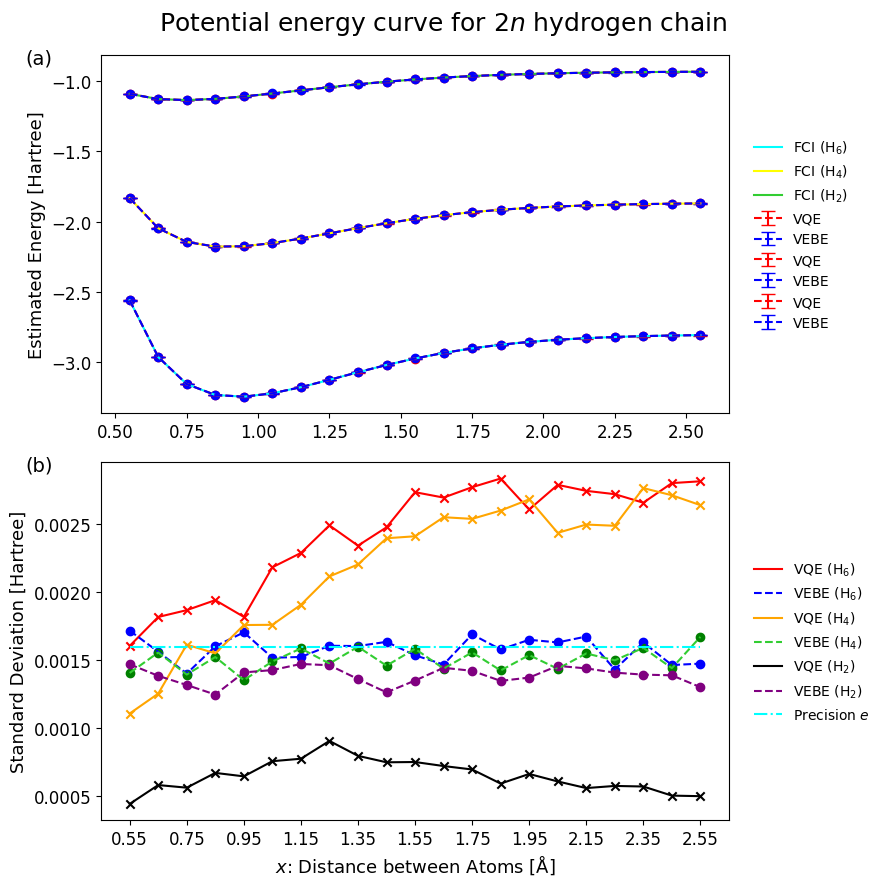

In [15]:
# === Step 13: Ilustrate graph of energy curve and unbiased standard deviation (Fig. 3) ===
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=False, sharey=False)

# === Step 13.1: Graph for comparironn of the energy curve ===
ax = axes[0]
# H6
ax.errorbar(dislist_h6_2, energy_vqe_h6_list, yerr=[std_vqe_h6_list, std_vqe_h6_list],
            linestyle='--', label='VQE', color='red', capsize=5)
ax.errorbar(dislist_h6, energy_vebe_h6_list, yerr=[std_vebe_h6_list, std_vebe_h6_list],
            linestyle='--', label='VEBE', color='blue', capsize=5)
ax.scatter(dislist_h6_2, energy_vqe_h6_list, color='red')
ax.scatter(dislist_h6, energy_vebe_h6_list, color='blue')            

# H4
ax.errorbar(dislist_h4_2, energy_vqe_h4_list, yerr=[std_vqe_h4_list, std_vqe_h4_list],
            linestyle='--', label='VQE', color='red', capsize=5)
ax.errorbar(dislist_h4, energy_vebe_h4_list, yerr=[std_vebe_h4_list, std_vebe_h4_list],
            linestyle='--', label='VEBE', color='blue', capsize=5)
ax.scatter(dislist_h4_2, energy_vqe_h4_list, color='red')
ax.scatter(dislist_h4, energy_vebe_h4_list, color='blue')

# H2
ax.errorbar(dislist_h2_2, energy_vqe_h2_list, yerr=[std_vqe_h2_list, std_vqe_h2_list],
            linestyle='--', label='VQE', color='red', capsize=5)
ax.errorbar(dislist_h2, energy_vebe_h2_list, yerr=[std_vebe_h2_list, std_vebe_h2_list],
            linestyle='--', label='VEBE', color='blue', capsize=5)
ax.scatter(dislist_h2_2, energy_vqe_h2_list, color='red')
ax.scatter(dislist_h2, energy_vebe_h2_list, color='blue')

ax.plot(dislist_h6, fci_list_h6, label=r'FCI (H$_6$)', color='cyan')
ax.plot(dislist_h4, fci_list_h4, label=r'FCI (H$_4$)', color='yellow')
ax.plot(dislist_h2, fci_list_h2, label=r'FCI (H$_2$)', color='limegreen')

ax.set_ylabel("Estimated Energy [Hartree]", fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.text(-0.12, 1.02, "(a)", transform=ax.transAxes,
        fontsize=14, va='top')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=False)

# === Step 13.2: Graph for comparison of the srtandard deviation ===
ax = axes[1]
# H6
ax.plot(dislist_h6_2, std_vqe_h6_list, linestyle='-', label=r'VQE (H$_6$)', color='red')
ax.plot(dislist_h6, std_vebe_h6_list, linestyle='--', label=r'VEBE (H$_6$)', color='blue')
ax.scatter(dislist_h6_2, std_vqe_h6_list, color='red', marker='x')
ax.scatter(dislist_h6, std_vebe_h6_list, color='blue')

# H4
ax.plot(dislist_h4_2, std_vqe_h4_list, linestyle='-', label=r'VQE (H$_4$)', color='orange')
ax.plot(dislist_h4, std_vebe_h4_list, linestyle='--', label=r'VEBE (H$_4$)', color='limegreen')
ax.scatter(dislist_h4_2, std_vqe_h4_list, color='orange', marker='x')
ax.scatter(dislist_h4, std_vebe_h4_list, color='green')

# H2
ax.plot(dislist_h2_2, std_vqe_h2_list, linestyle='-', label=r'VQE (H$_2$)', color='black')
ax.plot(dislist_h2, std_vebe_h2_list, linestyle='--', label=r'VEBE (H$_2$)', color='purple')
ax.scatter(dislist_h2_2, std_vqe_h2_list, color='black', marker='x')
ax.scatter(dislist_h2, std_vebe_h2_list, color='purple')

ax.hlines(1.6e-3, dislist_h6[0], dislist_h6[-1], linestyles='-.', label=r'Precision $e$', color='cyan')

ax.set_xlabel(r"$x$: Distance between Atoms [Å]", fontsize=13)
ax.set_ylabel("Standard Deviation [Hartree]", fontsize=13)
ax.set_xticks(np.arange(
    dislist_h2[0],
    dislist_h2[-1] + (dislist_h2[-1] - dislist_h2[0]) / len(dislist_h2),
    2 * (dislist_h2[-1] - dislist_h2[0]) / (len(dislist_h2) - 1)
))
ax.tick_params(axis='both', labelsize=12)
ax.text(-0.12, 1.02, "(b)", transform=ax.transAxes,
        fontsize=14, va='top')        
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=False)

# === Step 13.3: Plot and save figures ===
plt.suptitle(r"Potential energy curve for $2n$ hydrogen chain", fontsize=18, x=0.45)#, fontweight='')
plt.tight_layout(rect=[0, 0, 0.9, 1])  
base_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
out_dir = os.path.join(
    base_dir, "..", "data", "pdf", "energy_curve", "Hydro_chain"
)
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, f"hydro_{time}.pdf")
plt.savefig(pdf_path, bbox_inches='tight')
plt.show()

In [16]:
# === Step 14: Print unbiased standard deviation of H6 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h6)):
    print(std_vebe_h6_list[i]**2, std_vqe_h6_list[i]**2, dislist_h6[i])

----- VEBE ----- ------ VQE ------ ---distance---
2.949990116247913e-06 2.5768085318651833e-06 0.55
2.440899315607655e-06 3.30616883714967e-06 0.65
1.964118551714308e-06 3.491749160266241e-06 0.75
2.5673727019468394e-06 3.7724725408722815e-06 0.8500000000000001
2.9068589577590586e-06 3.309161682119572e-06 0.9500000000000001
2.3049487950864344e-06 4.772143740824386e-06 1.05
2.321430263761781e-06 5.243473907734458e-06 1.1500000000000001
2.5802145419462256e-06 6.214666644894415e-06 1.25
2.5726501604125737e-06 5.493952440352487e-06 1.35
2.673867097010046e-06 6.144206835672645e-06 1.4500000000000002
2.3597124091683813e-06 7.494139136482123e-06 1.55
2.155315157236005e-06 7.2785613431030536e-06 1.65
2.8558004835992834e-06 7.697373507036344e-06 1.75
2.4930129004776346e-06 8.05562536420549e-06 1.8499999999999999
2.7237090978717597e-06 6.812841853135982e-06 1.9499999999999997
2.66013609880199e-06 7.793544468637935e-06 2.05
2.8029218817081623e-06 7.5483799136521145e-06 2.15
2.048480932406444e-06 

In [17]:
# === Step 15: Print unbiased standard deviation of H4 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h4)):
    print(std_vebe_h4_list[i]**2, std_vqe_h4_list[i]**2, dislist_h4[i])

----- VEBE ----- ------ VQE ------ ---distance---
1.977120501108793e-06 1.2258055823883787e-06 0.55
2.4226972571253357e-06 1.5717325349408094e-06 0.65
1.9439448963679375e-06 2.6059784039354236e-06 0.75
2.319855384678268e-06 2.403051677145443e-06 0.8500000000000001
1.8309815276503652e-06 3.0942593989289174e-06 0.9500000000000001
2.2219451863131626e-06 3.099768094696892e-06 1.05
2.5162143564501744e-06 3.6405515011163295e-06 1.1500000000000001
2.175673943316008e-06 4.482422782787156e-06 1.25
2.556170549020191e-06 4.862972814267588e-06 1.35
2.1300479079972006e-06 5.751725482813421e-06 1.4500000000000002
2.508879588588922e-06 5.821766399663753e-06 1.55
2.0675241036556628e-06 6.519005622132441e-06 1.65
2.4256628874154706e-06 6.45700905591704e-06 1.75
2.0283754617064854e-06 6.771911043397532e-06 1.8499999999999999
2.3638171246321403e-06 7.208290571701712e-06 1.95
2.0637572813447085e-06 5.944478723865312e-06 2.05
2.4008487869444863e-06 6.245941483665263e-06 2.15
2.247580907229272e-06 6.2010001

In [18]:
# === Step 16: Print unbiased standard deviation of H2 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h2)):
    print(std_vebe_h2_list[i]**2, std_vqe_h2_list[i]**2, dislist_h2[i])

----- VEBE ----- ------ VQE ------ ---distance---
2.1601053562160733e-06 1.9461653156614046e-07 0.55
1.91772787319399e-06 3.3650852525836536e-07 0.65
1.7351315618709309e-06 3.1452561250163156e-07 0.75
1.5539720767476402e-06 4.484538623954055e-07 0.8500000000000001
1.9874308292411974e-06 4.150467321009554e-07 0.9500000000000001
2.0370809090019728e-06 5.713971775470549e-07 1.05
2.1672603374255265e-06 5.99205510595871e-07 1.1500000000000001
2.139803222887119e-06 8.195048054226124e-07 1.25
1.8522154213098717e-06 6.324651744182586e-07 1.35
1.5949702860500164e-06 5.59215153078799e-07 1.4500000000000002
1.822428271216968e-06 5.622536444424502e-07 1.55
2.0847708568175372e-06 5.187892348620444e-07 1.65
2.0215836047914727e-06 4.8291691399718e-07 1.75
1.815720758443597e-06 3.493382866189248e-07 1.8499999999999999
1.8822218223244694e-06 4.379606111505429e-07 1.95
2.1254083602796147e-06 3.6808767689849046e-07 2.05
2.0724840313086413e-06 3.1121132384495467e-07 2.15
1.9832913837987977e-06 3.290790323

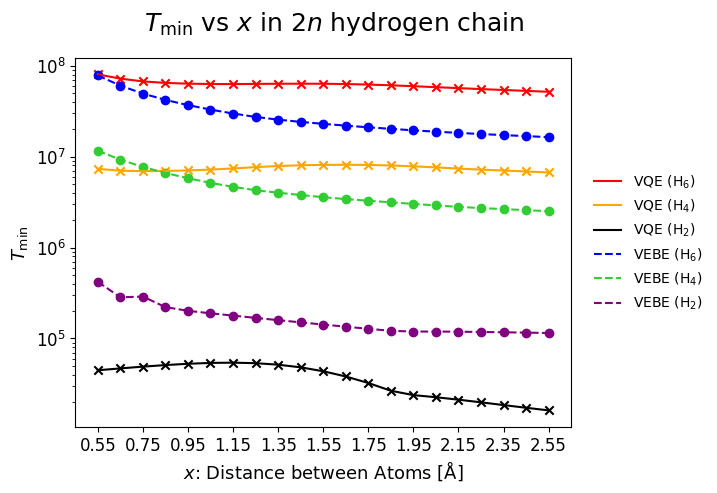

In [19]:
# === Step 17: Ilustrate graph of analytical necessary number of measurements (Fig.4) ===
fig, ax = plt.subplots()
# VQE
ax.plot(dislist_h6_2, num_vqe_h6_list, label=r'VQE (H$_6$)', linestyle='-', color='red')
ax.plot(dislist_h4_2, num_vqe_h4_list, label=r'VQE (H$_4$)', linestyle='-', color='orange')
ax.plot(dislist_h2_2, num_vqe_h2_list, label=r'VQE (H$_2$)', linestyle='-', color='black')
ax.scatter(dislist_h6_2, num_vqe_h6_list, color='red', marker='x')
ax.scatter(dislist_h4_2, num_vqe_h4_list, color='orange', marker='x')
ax.scatter(dislist_h2_2, num_vqe_h2_list, color='black', marker='x')

# VEBE
ax.plot(dislist_h6, np.array(num_vebe_h6_list), label=r'VEBE (H$_6$)', linestyle='--', color='blue')
ax.plot(dislist_h4, np.array(num_vebe_h4_list), label=r'VEBE (H$_4$)', linestyle='--', color='limegreen')
ax.plot(dislist_h2, np.array(num_vebe_h2_list), label=r'VEBE (H$_2$)', linestyle='--', color='purple')
ax.scatter(dislist_h6, num_vebe_h6_list, color='blue')
ax.scatter(dislist_h4, num_vebe_h4_list, color='limegreen')
ax.scatter(dislist_h2, num_vebe_h2_list, color='purple')

ax.set_yscale("log") 
ax.set_xlabel(r"$x$: Distance between Atoms [Å]", fontsize=13)
ax.set_ylabel(r"$T_{\text{min}}$", fontsize=13)
ax.set_xticks(np.arange(
    dislist_h2[0],
    dislist_h2[-1] + (dislist_h2[-1] - dislist_h2[0]) / len(dislist_h2),
    2 * (dislist_h2[-1] - dislist_h2[0]) / (len(dislist_h2) - 1)
))
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=False)

base_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
out_dir = os.path.join(
    base_dir, "..", "data", "pdf", "number_of_measurement", "Hydro_chain"
)
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, f"hydro_{time}.pdf")
plt.suptitle(r"$T_{\text{min}}$ vs $x$ in $2n$ hydrogen chain", fontsize=18, x=0.53)
plt.savefig(pdf_path, bbox_inches='tight')
plt.show()

In [20]:
# === Step 18: Print analytical necessary number of measurements of H6 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h6)):
    print(num_vebe_h6_list[i], num_vqe_h6_list[i], dislist_h6[i])

----- VEBE ----- ------ VQE ------ ---distance---
78158474.50162219 80233516.22337373 0.55
60400973.62052627 72108466.16818035 0.65
49347419.665007256 67181877.44291206 0.75
42059599.675676726 64679690.00170986 0.8500000000000001
36848409.0928795 63429058.82303197 0.9500000000000001
32893985.865059406 62881770.63390454 1.05
29789902.87808279 62791924.340037234 1.1500000000000001
27326198.18944271 63033899.630400166 1.25
25503153.691023972 63295936.72894631 1.35
24087843.35988947 63380321.76875578 1.4500000000000002
22927580.906348154 63316134.808307365 1.55
21907033.79739919 62851393.769251004 1.65
21005647.027643397 62015963.722395256 1.75
20196282.952171907 60862781.47638573 1.8499999999999999
19459611.60488924 59482942.701219134 1.9499999999999997
18802297.443391297 58035438.95900192 2.05
18239611.08507082 56683773.6793829 2.15
17703020.847526744 55286696.56802979 2.25
17243484.388986807 54057481.816300526 2.3499999999999996
16804318.581714332 52844386.96757407 2.4499999999999997
16

In [21]:
# === Step 19: Print analytical necessary number of measurements of H4 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h4)):
    print(num_vebe_h4_list[i], num_vqe_h4_list[i], dislist_h4[i])

----- VEBE ----- ------ VQE ------ ---distance---
11632913.032428244 7339862.443260403 0.55
9250985.319576055 6996087.252085811 0.65
7707258.562562359 6920329.156457551 0.75
6612357.082442363 6954654.702802913 0.8500000000000001
5788963.142585682 7051453.046570785 0.9500000000000001
5146900.182275391 7195599.165390407 1.05
4650195.19950977 7411789.00068277 1.1500000000000001
4270180.11236854 7663589.531365738 1.25
4010402.66717089 7881218.065893104 1.35
3780703.2976612197 8037123.174156129 1.4500000000000002
3575980.744864603 8109933.486709193 1.55
3410952.7617310574 8136999.471087042 1.65
3271301.172826183 8103630.485394754 1.75
3141358.504655798 7990858.277967635 1.8499999999999999
3020228.001263976 7819813.271381274 1.95
2906935.245810363 7611499.378176062 2.05
2800691.692618542 7383585.086365022 2.15
2715485.8964910554 7191696.633824711 2.25
2645924.1661012354 7032184.32876402 2.3499999999999996
2576563.4535808405 6864990.563615146 2.4499999999999997
2507721.6711747795 6693515.0331

In [22]:
# === Step 20: Print analytical necessary number of measurements of H2 ===
print('----- VEBE -----', '------ VQE ------', '---distance---')
for i in range(len(dislist_h2)):
    print(num_vqe_h2_list[i], num_vqe_h4_list[i], dislist_h2[i])

----- VEBE ----- ------ VQE ------ ---distance---
44681.715992622456 7339862.443260403 0.55
46820.918738079 6996087.252085811 0.65
48950.82613390567 6920329.156457551 0.75
50945.34794228471 6954654.702802913 0.8500000000000001
52636.53410708371 7051453.046570785 0.9500000000000001
53799.25214624619 7195599.165390407 1.05
54161.87036082083 7411789.00068277 1.1500000000000001
53449.611859124976 7663589.531365738 1.25
51455.51092047004 7881218.065893104 1.35
48119.27479010783 8037123.174156129 1.4500000000000002
43580.70253822351 8109933.486709193 1.55
38174.46647793519 8136999.471087042 1.65
32357.288149595246 8103630.485394754 1.75
26596.31925693387 7990858.277967635 1.8499999999999999
23801.22744464236 7819813.271381274 1.95
22568.56482204385 7611499.378176062 2.05
21207.776609753084 7383585.086365022 2.15
19827.69461433136 7191696.633824711 2.25
18502.305171143496 7032184.32876402 2.3499999999999996
17275.481170799663 6864990.563615146 2.4499999999999997
16168.703794631545 6693515.033